![](../banner.png)
# Feature engineering + class imbalance
This notebook shows feature engineering steps and my approach to addressing the imbalanced class distribution of the data set.
## Import libraries
As usual, I first imported the required libraries:

In [1]:
import pandas as pd
from pandas.io import sql
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
 
plt.style.use('ggplot')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

## Import dataset
I then imported the dataset I created:

In [2]:
df = pd.read_csv(f'../df_final.csv')
df.drop(columns = 'Unnamed: 0', inplace = True)
print(df.shape)
df.head()

(2074393, 16)


,side_effect,category,gender,age,year,sender_type,is_consumer,is_hcp,severity,db_id,drug,target,drug_cat,condition,rating,n_reviews
0,eosinophilia,blood,female,0.0,1991.0,indirect,n,y,s,DB00125,arginine,"['Nitric oxide synthase, endothelial', 'Cation...",NaN,"diagnosis and investigation, dietary supplemen...",9.4,5
1,chest discomfort,genrl,unknown,60.0,1994.0,direct,n,y,s,DB00125,arginine,"['Nitric oxide synthase, endothelial', 'Cation...",NaN,"diagnosis and investigation, dietary supplemen...",9.4,5
2,feeling abnormal,genrl,unknown,60.0,1994.0,direct,n,y,s,DB00125,arginine,"['Nitric oxide synthase, endothelial', 'Cation...",NaN,"diagnosis and investigation, dietary supplemen...",9.4,5
3,feeling hot,genrl,unknown,60.0,1994.0,direct,n,y,s,DB00125,arginine,"['Nitric oxide synthase, endothelial', 'Cation...",NaN,"diagnosis and investigation, dietary supplemen...",9.4,5
4,flushing,vasc,unknown,60.0,1994.0,direct,n,y,s,DB00125,arginine,"['Nitric oxide synthase, endothelial', 'Cation...",NaN,"diagnosis and investigation, dietary supplemen...",9.4,5


Before jumping into addressing the class imbalance, I first performed some feature engineering. 

# Feature engineering

## Sample data set
Due to limited computational power, I had to sample a portion of the entire dataset, while retaining the class distributions, to avoid killing the kernel.

In [3]:
df.severity.value_counts()

s    1552733
n     398000
f     123660
Name: severity, dtype: int64

In [4]:
# subset into class 's'
s = df[df.severity == 's'].copy()
# sample 20% of class 's'
sample_s = s.sample(frac = 0.2, random_state = 1)

# same for class 'n'
n = df[df.severity == 'n'].copy()
sample_n = n.sample(frac = 0.2, random_state = 1)

# and class 'f'
f = df[df.severity == 'f'].copy()
sample_f = f.sample(frac = 0.2, random_state = 1)

# check lengths
len(sample_s), len(sample_n), len(sample_f)

(310547, 79600, 24732)

In [5]:
df_sampled = pd.concat([sample_f, sample_n, sample_s], axis = 0)
df_sampled.severity.value_counts()

s    310547
n     79600
f     24732
Name: severity, dtype: int64

In [6]:
df_sampled.sort_index(inplace = True)
df_sampled.head()

,side_effect,category,gender,age,year,sender_type,is_consumer,is_hcp,severity,db_id,drug,target,drug_cat,condition,rating,n_reviews
5,pain,genrl,unknown,60.0,1994.0,direct,n,y,s,DB00125,arginine,"['Nitric oxide synthase, endothelial', 'Cation...",NaN,"diagnosis and investigation, dietary supplemen...",9.4,5
7,hypersensitivity,immun,female,20.0,1991.0,direct,n,y,n,DB00125,arginine,"['Nitric oxide synthase, endothelial', 'Cation...",NaN,"diagnosis and investigation, dietary supplemen...",9.4,5
9,rash macular,skin,female,20.0,1991.0,direct,n,y,n,DB00125,arginine,"['Nitric oxide synthase, endothelial', 'Cation...",NaN,"diagnosis and investigation, dietary supplemen...",9.4,5
10,hypersensitivity,immun,female,20.0,1991.0,direct,n,y,n,DB00125,arginine,"['Nitric oxide synthase, endothelial', 'Cation...",NaN,"diagnosis and investigation, dietary supplemen...",9.4,5
15,rash erythematous,skin,male,40.0,1992.0,indirect,n,y,n,DB00125,arginine,"['Nitric oxide synthase, endothelial', 'Cation...",NaN,"diagnosis and investigation, dietary supplemen...",9.4,5


In [7]:
# df_sampled.to_csv('df_sampled_20.csv')

In [5]:
df_sampled = pd.read_csv('../df_sampled_20.csv')
df_sampled.drop(columns = 'Unnamed: 0', inplace = True)

In [8]:
df_sampled.shape, df.shape

((414879, 16), (2074393, 16))

In [6]:
df_sampled.head()

,side_effect,category,gender,age,year,sender_type,is_consumer,is_hcp,severity,db_id,drug,target,drug_cat,condition,rating,n_reviews
0,pain,genrl,unknown,60.0,1994.0,direct,n,y,s,DB00125,arginine,"['Nitric oxide synthase, endothelial', 'Cation...",NaN,"diagnosis and investigation, dietary supplemen...",9.4,5
1,hypersensitivity,immun,female,20.0,1991.0,direct,n,y,n,DB00125,arginine,"['Nitric oxide synthase, endothelial', 'Cation...",NaN,"diagnosis and investigation, dietary supplemen...",9.4,5
2,rash macular,skin,female,20.0,1991.0,direct,n,y,n,DB00125,arginine,"['Nitric oxide synthase, endothelial', 'Cation...",NaN,"diagnosis and investigation, dietary supplemen...",9.4,5
3,hypersensitivity,immun,female,20.0,1991.0,direct,n,y,n,DB00125,arginine,"['Nitric oxide synthase, endothelial', 'Cation...",NaN,"diagnosis and investigation, dietary supplemen...",9.4,5
4,rash erythematous,skin,male,40.0,1992.0,indirect,n,y,n,DB00125,arginine,"['Nitric oxide synthase, endothelial', 'Cation...",NaN,"diagnosis and investigation, dietary supplemen...",9.4,5


## Separate out target variable from predicting variables
First, I divided the data set into `X` (predicting variables) and `y` (target variable, `severity`).

In [7]:
X = df_sampled.copy()
y = X.pop('severity')

In [10]:
# columns in X data frame
X.columns

Index(['side_effect', 'category', 'gender', 'age', 'year', 'sender_type',
       'is_consumer', 'is_hcp', 'db_id', 'drug', 'target', 'drug_cat',
       'condition', 'rating', 'n_reviews'],
      dtype='object')

## Data Cleaning
### Drop db_id column
I dropped the Drugbank ID column as it is not needed for modelling.

In [8]:
X.drop(columns = 'db_id', inplace = True)

### Fill null values with string 'na'
I filled null values with a string of 'na' to consider them as a separate category once I dummified the necessary columns.

In [9]:
X.fillna('na', inplace = True)
X.isnull().sum()

side_effect    0
category       0
gender         0
age            0
year           0
sender_type    0
is_consumer    0
is_hcp         0
drug           0
target         0
drug_cat       0
condition      0
rating         0
n_reviews      0
dtype: int64

##### Overview

In [13]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 414879 entries, 5 to 2074392
Data columns (total 14 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   side_effect  414879 non-null  object 
 1   category     414879 non-null  object 
 2   gender       414879 non-null  object 
 3   age          414879 non-null  float64
 4   year         414879 non-null  float64
 5   sender_type  414879 non-null  object 
 6   is_consumer  414879 non-null  object 
 7   is_hcp       414879 non-null  object 
 8   drug         414879 non-null  object 
 9   target       414879 non-null  object 
 10  drug_cat     414879 non-null  object 
 11  condition    414879 non-null  object 
 12  rating       414879 non-null  float64
 13  n_reviews    414879 non-null  int64  
dtypes: float64(3), int64(1), object(10)
memory usage: 47.5+ MB


In [14]:
X.describe()

,age,year,rating,n_reviews
count,414879.000000,414879.000000,414879.000000,414879.000000
mean,48.298878,2006.125596,7.204289,962.753658
std,19.650410,12.412804,1.318007,2699.863269
min,0.000000,1963.000000,1.000000,1.000000
25%,30.000000,1999.000000,6.357798,35.000000
50%,50.000000,2010.000000,7.270929,176.000000
75%,60.000000,2016.000000,8.146479,758.000000
max,100.000000,2020.000000,10.000000,20980.000000


In [15]:
X.side_effect.value_counts().head(10)

rash         8609
nausea       7957
headache     7430
dizziness    6730
diarrhoea    5967
vomiting     5762
pruritus     4966
dyspnoea     4763
malaise      4743
urticaria    4161
Name: side_effect, dtype: int64

In [16]:
X.drug.value_counts().head(10)

clozapine           25141
paroxetine           7213
varenicline          5358
fluoxetine           4393
ethinylestradiol     4349
paracetamol          4310
etanercept           4278
bupropion            4233
amoxycillin          4227
adalimumab           4159
Name: drug, dtype: int64

## Train-test split
I performed train-test split at 80/20 split, and included the argument `stratify = y` to retain class distribution in both training and test sets.

In [10]:
# train test split
from sklearn.model_selection import train_test_split, cross_val_score

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, stratify = y, random_state = 1)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(331903, 14) (331903,)
(82976, 14) (82976,)


In [11]:
X_train.head()

,side_effect,category,gender,age,year,sender_type,is_consumer,is_hcp,drug,target,drug_cat,condition,rating,n_reviews
45461,cyanosis,vasc,female,60.0,2017.0,direct,n,y,hydrocortisone,"['Glucocorticoid receptor', 'Annexin A1']",68:04.00 — Adrenals,"acne, dermatitis, pruritus, hemorrhoids, psori...",7.753846,130
316836,angioedema,skin,female,40.0,2018.0,indirect,y,n,ascorbic acid,"['Hyaluronate lyase', 'DNA', 'Xylose isomerase...",88:12.00 — Vitamin C,dietary supplementation,7.750000,4
75702,somnolence,nerv,male,60.0,1987.0,direct,n,y,fluvoxamine,"['Sodium-dependent serotonin transporter', 'Po...",28:16.04.20 — Selective-serotonin Reuptake Inh...,"social anxiety disorder, anxiety and stress, o...",7.177966,236
337884,uterine hyperstimulation,preg,female,60.0,2009.0,indirect,n,y,dinoprostone,"['Prostaglandin E2 receptor EP2 subtype', 'Pro...",na,labor induction,3.800000,10
173043,illness,genrl,female,60.0,2012.0,indirect,y,n,doxorubicin,"['DNA', 'DNA topoisomerase 2-alpha', 'Nucleola...",10:00.00 — Antineoplastic Agents,"breast cancer, lymphoma, cancer",8.000000,7


In [12]:
y_train.head()

45461     s
316836    s
75702     n
337884    s
173043    s
Name: severity, dtype: object

## Column Transformer - categorical and text columns
`ColumnTransformer` allows converting different columns using different methods in one process. After trial and error, I decided the following:

##### Text columns:
- Create a custom stopword list for NLP, which contain words that appeared top when trialling but appear meaningless, e.g. 'like'.
- For `condition` column, `CountVectorizer` with `ngram_range` set to 2 words, with custom stopword list.
- For `side_effect` column, `CountVectorizer` with `ngram_range` set to 2 words, with custom stopword list.
- For `target` column, `CountVectorizer` with `ngram_range` set to 2 to 3 words, with custom stopword list.

##### Categorical columns:
- For all other categorical columns, use `OneHotEncoder`.

These are all incorporated into a `Pipeline` in the next steps.

In [13]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer

In [29]:
# make custom stopwords list for cvec and tvec
# appeared top when trialing but meaningless
cvec = CountVectorizer(stop_words = 'english')
stopwords = list(cvec.get_stop_words())
stopwords.extend(['nan', 'listed', 'othe', 've', 'mg', 'like',
                  'just', 'did', 'don', 'receptor'])

# create count vectorizer for condition column
cvec_condition = CountVectorizer(stop_words = stopwords,
                       max_features = 10000,
                       strip_accents = 'unicode',
                       lowercase = True,
                       decode_error = 'replace',
                       ngram_range = (2, 2),
                       min_df = 0.02)

# create count vectorizer for side_effect column
cvec_se = CountVectorizer(stop_words = stopwords,
                       max_features = 10000,
                       strip_accents = 'unicode',
                       lowercase = True,
                       decode_error = 'replace',
                       ngram_range = (2, 2),
                       min_df = 0.008)

# create count vectorizer for target column
cvec_target = CountVectorizer(stop_words = stopwords,
                       max_features = 10000,
                       strip_accents = 'unicode',
                       lowercase = True,
                       decode_error = 'replace',
                       ngram_range = (2, 3),
                       min_df = 0.008)

# create onehotencoder for all categorical columns
one_hot = OneHotEncoder(sparse=False, handle_unknown='ignore')

In [22]:
# # create tfidf vectorizer for review column
# tvec_review = TfidfVectorizer(stop_words = stopwords,
#                        max_features = 10000,
#                        norm = 'l2', 
#                        strip_accents = 'unicode',
#                        lowercase = True,
#                        decode_error = 'replace',
#                        ngram_range = (2, 2),
#                        min_df = 0.4,
#                        max_df = 0.9)

In [16]:
cats = ['category', 'gender', 'age', 'sender_type', 'is_consumer', 'is_hcp', 'drug', 'drug_cat']
texts = ['side_effect', 'target', 'condition'] #'review'
nums = ['year', 'rating', 'n_reviews']

In [30]:
# create column transformer
col_trans = ColumnTransformer([('categories', one_hot, cats),
                               ('side_effects', cvec_se, 'side_effect'),
                               ('conditions', cvec_condition, 'condition'),
                               ('targets', cvec_target, 'target')
                               #('reviews', tvec_review, 'review')
                              ],
                              remainder = 'passthrough',
                              sparse_threshold = 0)

## MinMaxScaler - numerical columns
I scaled the numerical columns and the vectorized text columns using `MinMaxScaler`, so that they fall between the range of 0 and 1. This way, the 0s and 1s from the dummified categorical columns are retained.

In [18]:
# create scaler 
scaler = MinMaxScaler()

# Class imbalance
The target variable is heavily skewed, with about 75% belonging to the class 'severe' side effects, and only 0.05% 'fatal' side effects.

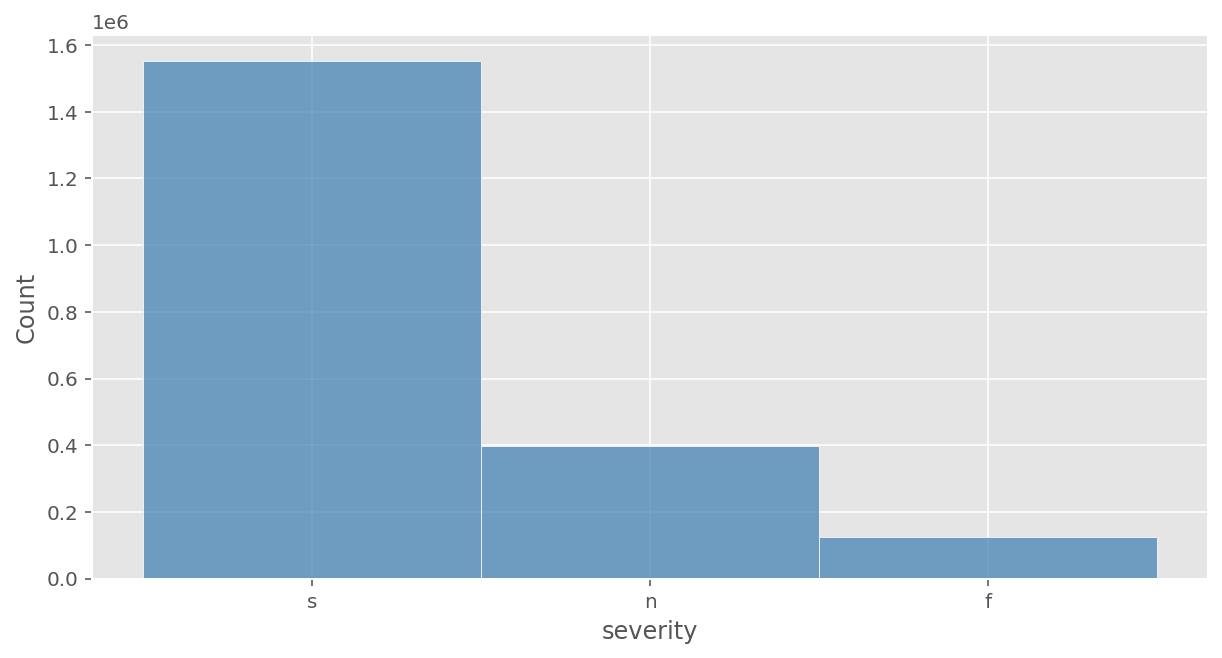

In [26]:
# target variable
f, ax = plt.subplots(figsize=(10, 5))
sns.histplot(df.severity, ax = ax, color = 'steelblue');

In [27]:
df.severity.value_counts(normalize = True)

s    0.748524
n    0.191863
f    0.059613
Name: severity, dtype: float64

## Attempt 1 - under-sample classes 's' and 'n'
In order to train my models in a way that does not favour the majority class, I have to address the imbalanced classes.

Initially, I decided to under-sample the majority class of the training set (class 's') to match the minority class, after performing train-test split at a 70%/30% split.

However, as the minority class only accounts for 0.05%, the final training set has fewer data points than the test set. Therefore, my model was not trained properly to obtain significant results.

In [19]:
y_train.value_counts()

s    248437
n     63680
f     19786
Name: severity, dtype: int64

In [20]:
y_test.value_counts()

s    62110
n    15920
f     4946
Name: severity, dtype: int64

In [30]:
# train set * under-sampled
print('Class s training set:', 248437 * 0.05)

Class s training set: 12421.85


## Attempt 2 - Combining under-sampling and SMOTE
My approach is to:
1. Train-test split
2. For training set:
    - Under-sample majority class (class 's') using `RandomUnderSampler`
    - Over-sample the other two classes ('n' and 'f') using `SMOTE` (Synthetic Minority Over-sampling Technique).

### SMOTE - over-sample class 'f'
I first over-sampled class 'f' to 10% of the majority class.

In [21]:
from imblearn.over_sampling import SMOTE

over = SMOTE(sampling_strategy = {'f': 24844}, random_state = 1)

### RUS - under-sample class 's'
I then under-sampled class 's' to match the number of data points in class 'n', which is 318400 for this data set.

In [22]:
# undersample
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(sampling_strategy = {'s': 63680}, random_state = 1)

### Pipeline
I now incorporate the `ColumnTransformer`, `SMOTE`, `RandomUnderSampler`, and `MinMaxScaler` into a Pipeline.

Because of the sampling methogs, I used the Pipeline from `imblearn` package instead of `scikit-learn`.

In [23]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter = 1000000)

In [31]:
# create pipeline
from imblearn.pipeline import Pipeline

pipe = Pipeline(steps=[('coltrans', col_trans),
                       ('scaler', scaler),
                       ('over', over),
                       ('under', rus),
                       ('model', lr)])

In [25]:
# diplay pipeline
from sklearn import set_config
set_config(display='diagram')   
pipe

Pipeline(steps=[('coltrans',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('categories',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['category', 'gender', 'age',
                                                   'sender_type', 'is_consumer',
                                                   'is_hcp', 'drug',
                                                   'drug_cat']),
                                                 ('side_effects',
                                                  CountVectorizer(decode_error='replace',
                                                                  max_features=10000,
                                                                  min_df=0.012,
                                                                  ngram_rang...
                                                                              'mostly',
                                                                              'us',
                                                                              'once',
                                                                              'anyway',
                                                                              'through',
                                                                              'fill',
                                                                              'after',
                                                                              'go',
                                                                              'behind',
                                                                              'me',
                                                                              'else',
                                                                              'mill',
                                                                              'anyhow',
                                                                              'until', ...],
                                                                  strip_accents='unicode'),
                                                  'target')])),
                ('scaler', MinMaxScaler()),
                ('over', SMOTE(random_state=1, sampling_strategy={'f': 24844})),
                ('under',
                 RandomUnderSampler(random_state=1,
                                    sampling_strategy={'s': 63680})),
                ('model', LogisticRegression(max_iter=1000000))])

### Logistic Regression + GridSearchCV

In [26]:
from sklearn.model_selection import GridSearchCV, cross_val_score

In [ ]:
# set parameters for GridSearchCV
params = {
    'model__C': np.logspace(-3, 2, 10),
    'model__penalty': ['l2'],
    'model__solver': ['saga'],
    'model__multi_class': ['ovr', 'multinomial']
}

# set up GridSearch
lr_grid = GridSearchCV(pipe, params, cv = 5,
                       n_jobs = -1, verbose = 3)

# fit training set
lr_grid.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


In [ ]:
cross_val_score(pipe, X_test, y_test, cv = 5, verbose = 1)

In [ ]:
# try pipeline with dask

with joblib.parallel_backend('dask'):
    # fit transform X_train
    X_train_processed = pipe.fit_transform(X_train)

In [ ]:
X_train_processed = pd.DataFrame(X_train_processed, columns = pipe.named_steps['coltrans'].get_feature_names())

In [ ]:
X_train_processed.info()

In [ ]:
X_train_processed.head()

In [ ]:
[col for col in X_train_processed.columns if 'side_effects' in col]

In [ ]:
 # transform X_test
with joblib.parallel_backend('dask'):
    X_test_processed = pipe.transform(X_test)

In [ ]:
X_test_processed = pd.DataFrame(X_test_processed, columns = pipe.named_steps['coltrans'].get_feature_names())
X_test_processed.info()

In [ ]:
X_test_processed.shape, y_test.shape

In [ ]:
X_train_processed.shape, y_train.shape

In [ ]:
# X_train_processed.to_csv('X_train_processed_2.csv', index = False)
# X_test_processed.to_csv('X_test_processed_2.csv', index = False)
# y_train.to_csv('y_train_2.csv', index = False)
# y_test.to_csv('y_test_2.csv', index = False)

In [ ]:
X_train_processed = pd.read_csv('X_train_processed_2.csv')
X_test_processed = pd.read_csv('X_test_processed_2.csv')
y_train = pd.read_csv('y_train_2.csv')
y_test = pd.read_csv('y_test_2.csv')

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score

In [ ]:
lr = LogisticRegression(max_iter = 100000)
lr.fit(X_train_processed, y_train)
print(cross_val_score(lr, X_train_processed, y_train, cv = 5).mean())

In [ ]:
# create logistic regression model
lr = LogisticRegression(max_iter = 100000)

# create params grid
gs_params = {'penalty': ['l2'],
             'solver': ['saga'],
             'C': np.logspace(-3, 2, 10),
             'multi_class': ['ovr', 'multinomial']}

# create gridsearch
lr_grid = GridSearchCV(lr, gs_params, n_jobs = 2, cv = 3, verbose = 3)
# fit gridsearch on training data
lr_grid.fit(X_train_processed, y_train)

In [ ]:
# assign best estimator
best_lr = lr_grid.best_estimator_

In [ ]:
joblib.dump(best_lr, 'best_lr.jlib')
# best_lr = joblib.load('best_lr.jlib')

In [ ]:
# print best params
print('Logreg best parameters: ', lr_grid.best_params_)
# print CV score
print('Best Score: ', lr_grid.best_score_)
# print training score
print('Training Score: ', lr_grid.score(X_train_processed, y_train))
# score best estimator on testing data
print('Test Score: ', lr_grid.score(X_test_processed, y_test))

# create a dataframe to look at the coefficients for class 0
coef_lr = pd.DataFrame({'feature': X_train_processed.columns,
                        'coef': best_lr.coef_[0],
                        'abs_coef': np.abs(best_lr.coef_[0])})

# sort by absolute value of coefficient (magnitude)
coef_lr.sort_values('abs_coef', ascending = False, inplace = True)
coef_lr.head()

In [ ]:
# joblib.dump(best_lr, 'best_lr.jlib')

In [ ]:
best_lr.classes_

In [ ]:
coef_lr.set_index('feature', inplace = True)
coef_lr.coef.head(20).plot(kind = 'barh', figsize = (10,10), color = 'b')

In [ ]:
coef_lr_n = pd.DataFrame({'feature': X_train_processed.columns,
                        'coef': best_lr.coef_[1],
                        'abs_coef': np.abs(best_lr.coef_[1])})

# sort by absolute value of coefficient (magnitude)
coef_lr_n.sort_values('abs_coef', ascending = False, inplace = True)
coef_lr_n.set_index('feature', inplace = True)
coef_lr_n.coef.head(20).plot(kind = 'barh', figsize = (10,10), color = 'b')

In [ ]:
coef_lr_s = pd.DataFrame({'feature': X_train_processed.columns,
                        'coef': best_lr.coef_[2],
                        'abs_coef': np.abs(best_lr.coef_[2])})

# sort by absolute value of coefficient (magnitude)
coef_lr_s.sort_values('abs_coef', ascending = False, inplace = True)
coef_lr_s.set_index('feature', inplace = True)
coef_lr_s.coef.head(20).plot(kind = 'barh', figsize = (10,10), color = 'b')

In [ ]:
print(classification_report(best_lr.predict(X_train_processed), y_train))
plot_confusion_matrix(best_lr, X_train_processed,  y_train, labels = ['n', 's', 'f'], cmap = 'Blues')

In [ ]:
print(classification_report(best_lr.predict(X_test_processed), y_test))
plot_confusion_matrix(best_lr, X_test_processed,  y_test, labels = ['n', 's', 'f'], cmap = 'Blues')

In [ ]:
plot_multiclass_roc(best_lr, X_train_processed , y_train, 3, figsize=(16, 10))
plot_multiclass_roc(best_lr, X_test_processed , y_test, 3, figsize=(16, 10))

In [ ]:
multiclass_precision_recall(best_lr, X_train_processed, y_train)
multiclass_precision_recall(best_lr, X_test_processed, y_test)

##### 

In [ ]:
y_train.head()

In [ ]:
y_train = np.ravel(y_train)

In [ ]:
# random forest

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(max_depth = 15, n_jobs = 2)
rf.fit(X_train_processed, y_train)

In [ ]:
cross_val_score(rf, X_train_processed, y_train, cv=5).mean()

In [ ]:
from sklearn.tree import export_graphviz
import graphviz

from ipywidgets import *
from IPython.display import display
from IPython.display import Image

In [ ]:
# random forest grid search
rf_params = {'n_estimators': [500, 700],
             'max_depth': range(5, 25, 5),
             'max_features': range(50, 110, 20)}

rf_grid = GridSearchCV(rf, rf_params, cv = 3, n_jobs = 2, verbose = 3)
rf_grid.fit(X_train_processed, y_train)

In [ ]:
# print best score and parameters
print(rf_grid.best_score_)
print(rf_grid.best_params_)

best_rf = rf_grid.best_estimator_

# refit best model, save cross_val_scores then .mean()

In [ ]:
rf_pred_train = best_rf.predict(X_train_processed)
rf_pred_test = best_rf.predict(X_test_processed)

In [ ]:
print(best_rf.score(X_train_processed, y_train))
print(best_rf.score(X_test_processed, y_test))

In [ ]:
from sklearn.metrics import plot_confusion_matrix, classification_report

In [ ]:
print(classification_report(rf_pred_train, y_train))
plot_confusion_matrix(best_rf, X_train_processed,  y_train, labels = ['n', 's', 'f'], cmap = 'Blues')

In [ ]:
print(classification_report(rf_pred_test, y_test))
plot_confusion_matrix(best_rf, X_test_processed,  y_test, labels = ['n', 's', 'f'], cmap = 'Blues')

In [ ]:
from sklearn.metrics import roc_curve, auc, roc_auc_score, plot_roc_curve, plot_precision_recall_curve
def plot_multiclass_roc(clf, X_test, y_test, n_classes, figsize=(17, 6)):
    y_score = clf.predict_proba(X_test)

    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    for i, y in enumerate(clf.classes_):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic curve')
    for i, y in enumerate(clf.classes_):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %s' % (roc_auc[i], y))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

plot_multiclass_roc(best_rf, X_test_processed , y_test, 3, figsize=(16, 10))

In [ ]:
plot_multiclass_roc(best_rf, X_train_processed , y_train, 3, figsize=(16, 10))

In [ ]:
best_rf.classes_

In [ ]:
# https://stackoverflow.com/questions/56090541/how-to-plot-precision-and-recall-of-multiclass-classifier

from sklearn.metrics import precision_recall_curve
def multiclass_precision_recall(model, X_test, y_test):
    y_score = model.predict_proba(X_test)
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    precision = dict()
    recall = dict()
    for i, y in enumerate(model.classes_):
        precision[i], recall[i], _ = precision_recall_curve(y_test_dummies[:, i],
                                                            y_score[:, i])
        plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(y))

    plt.xlabel("recall")
    plt.ylabel("precision")
    plt.legend(loc="best")
    plt.title("precision vs. recall curve")
    plt.show()
multiclass_precision_recall(best_rf, X_test_processed, y_test)

In [ ]:
multiclass_precision_recall(best_rf, X_train_processed, y_train)

In [ ]:
rf_features = np.mean([
    tree.feature_importances_ for tree in best_rf], axis = 0)
rf_feature_df = pd.DataFrame({'importances': rf_features}, index = X_train_processed.columns)
rf_feature_df.sort_values('importances', ascending = False).head(20)

In [ ]:
rf_feature_df.sort_values('importances', ascending = False).head(20).plot(kind = 'barh', figsize = (10, 10), color = 'b')

In [ ]:
import joblib
joblib.dump(best_rf, 'best_rf.jlib')

In [ ]:
# decision tree depth 5
dtc = DecisionTreeClassifier(max_depth = 5)
dtc.fit(X_train_processed, y_train)
dtc_scores = cross_val_score(dtc, X_train_processed, y_train, cv = 5)
print(dtc_scores.mean())

In [ ]:
# then grid search decision tree
# random forest grid search
dtc2 = DecisionTreeClassifier()

dt_params = {'max_depth': range(5, 25, 5),
             'max_features': range(50, 110, 20)}

dt_grid = GridSearchCV(dtc2, dt_params, cv = 5, n_jobs = 2, verbose = 3)
dt_grid.fit(X_train_processed, y_train)

In [ ]:
# print best score and parameters
print(dt_grid.best_score_)
print(dt_grid.best_params_)

best_dt = dt_grid.best_estimator_

# refit best model, save cross_val_scores then .mean()

In [ ]:
joblib.dump(best_dt, 'best_dt.jlib')

In [ ]:
print(best_dt.score(X_train_processed, y_train))
print(best_dt.score(X_test_processed, y_test))

In [ ]:
print(classification_report(best_dt.predict(X_train_processed), y_train))
plot_confusion_matrix(best_dt, X_train_processed,  y_train, labels = ['n', 's', 'f'], cmap = 'Blues')

In [ ]:
print(classification_report(best_dt.predict(X_test_processed), y_test))
plot_confusion_matrix(best_dt, X_test_processed,  y_test, labels = ['n', 's', 'f'], cmap = 'Blues')

In [ ]:
plot_multiclass_roc(best_dt, X_test_processed, y_test, 3, figsize = (10, 6))

In [ ]:
plot_multiclass_roc(best_dt, X_train_processed, y_train, 3, figsize = (10, 6))

In [ ]:
multiclass_precision_recall(best_dt, X_test_processed, y_test)

In [ ]:
multiclass_precision_recall(best_dt, X_train_processed, y_train)

In [ ]:
dt_feature_df = pd.DataFrame({'importances': best_dt.feature_importances_}, index = X_train_processed.columns)
dt_feature_df.sort_values('importances', ascending = False).head(20)

In [ ]:
dt_feature_df.sort_values('importances', ascending = False).head(20).plot(kind = 'barh', figsize = (10, 10), color = 'b')

In [ ]:
# AdaBoost max depth 3

from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier

In [ ]:
base_estimator = DecisionTreeClassifier(max_depth=3, max_features=0.3)
ada = AdaBoostClassifier(base_estimator=base_estimator,
                           n_estimators=100,
                           random_state=1)
ada.fit(X_train_processed, y_train)

print(ada.score(X_train_processed, y_train))
print(cross_val_score(ada, X_train_processed, y_train, cv=5).mean())
print(ada.score(X_test_processed, y_test))

In [ ]:
joblib.dump(ada, 'ada.jlib')

In [ ]:
plt.plot(list(ada.staged_score(X_train_processed, y_train)),
         label='training score', lw=2)
plt.plot(list(ada.staged_score(X_test_processed, y_test)), label='test score', lw=2)
plt.xlabel('iteration')
plt.ylabel('score')
plt.legend()
plt.show()

In [ ]:
print(classification_report(ada.predict(X_train_processed), y_train))
plot_confusion_matrix(ada, X_train_processed,  y_train, labels = ['n', 's', 'f'], cmap = 'Blues')

In [ ]:
print(classification_report(ada.predict(X_test_processed), y_test))
plot_confusion_matrix(ada, X_test_processed,  y_test, labels = ['n', 's', 'f'], cmap = 'Blues')

In [ ]:
plot_multiclass_roc(ada, X_test_processed, y_test, 3, figsize = (10, 6))

In [ ]:
plot_multiclass_roc(ada, X_train_processed, y_train, 3, figsize = (10, 6))

In [ ]:
multiclass_precision_recall(ada, X_test_processed, y_test)

In [ ]:
multiclass_precision_recall(ada, X_train_processed, y_train)

In [ ]:
ada_feature_df = pd.DataFrame({'importances': ada.feature_importances_}, index = X_train_processed.columns)
ada_feature_df.sort_values('importances', ascending = False).head(20)

In [ ]:
ada_feature_df.sort_values('importances', ascending = False).head(20).plot(kind = 'barh', figsize = (10, 10), color = 'b')

In [ ]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier

In [ ]:
hb = HistGradientBoostingClassifier(max_depth = 3)

hb.fit(X_train_processed, y_train)
hb_scores = cross_val_score(hb, X_train_processed, y_train, cv=5)

print(hb_scores.mean())
print(ada.score(X_train_processed, y_train))
print(ada.score(X_test_processed, y_test))

In [ ]:
joblib.dump(hb, 'histboost.joblib')

In [ ]:
# Naive Bayes
from sklearn import naive_bayes

In [ ]:
nb = naive_bayes.MultinomialNB()

alphas = {'alpha': np.linspace(0.0001, 1.0, 10)}
nb_grid = GridSearchCV(nb, alphas, cv = 5, n_jobs = 2, verbose = 3)
nb_grid.fit(X_train_processed, y_train)

print(nb_grid.best_score_)
print(nb_grid.best_params_)
best_nb = nb_grid.best_estimator_
print(best_nb.score(X_train_processed, y_train))
print(best_nb.score(X_test_processed, y_test))
# nb_scores = cross_val_score(nb, X_train_processed, y_train, cv=5)
# print(nb_scores.mean())
# print(nb.score(X_train_processed, y_train))
# print(nb.score(X_test_processed, y_test))

In [ ]:
print(classification_report(best_nb.predict(X_train_processed), y_train))
plot_confusion_matrix(best_nb, X_train_processed,  y_train, labels = ['n', 's', 'f'], cmap = 'Blues')

In [ ]:
print(classification_report(best_nb.predict(X_test_processed), y_test))
plot_confusion_matrix(best_nb, X_test_processed,  y_test, labels = ['n', 's', 'f'], cmap = 'Blues')

In [ ]:
plot_multiclass_roc(best_nb, X_test_processed, y_test, 3, figsize = (10, 6))
multiclass_precision_recall(best_nb, X_test_processed, y_test)

In [ ]:
plot_multiclass_roc(best_nb, X_train_processed, y_train, 3, figsize = (10, 6))
multiclass_precision_recall(best_nb, X_train_processed, y_train)

In [ ]:
best_nb.classes_

In [ ]:
np.exp(best_nb.feature_log_prob_[0])

In [ ]:
nb_feature_df = pd.DataFrame({'class_f': np.exp(best_nb.feature_log_prob_[0]),
                              'class_n': np.exp(best_nb.feature_log_prob_[1]),
                              'class_s': np.exp(best_nb.feature_log_prob_[2])},
                             index = X_train_processed.columns)
nb_feature_df.head()

In [ ]:
nb_feature_df['class_f'].sort_values(ascending = False).head(20).plot(kind = 'barh', figsize = (10, 10), color = 'b')

In [ ]:
nb_feature_df['class_s'].sort_values(ascending = False).head(20).plot(kind = 'barh', figsize = (10, 10), color = 'b')

In [ ]:
nb_feature_df['class_n'].sort_values(ascending = False).head(20).plot(kind = 'barh', figsize = (10, 10), color = 'b')

In [ ]:
# SVC
from sklearn.svm import SVC

In [ ]:
svc = SVC()
params = {'kernel': ['rbf', 'sigmoid'],
          'C': np.logspace(-4, 2, 10),
          'gamma': ['scale', 'auto']}

svc_grid = GridSearchCV(svc, params, cv = 3, verbose = 3, n_jobs = -2)
svc_grid.fit(X_train_processed, y_train)

print(svc_grid.best_params_)
print(svc_grid.best_score_)

best_svc = svc_grid.best_estimator_

print(best_svc.score(X_train_processed, y_train))
print(best_svc.score(X_test_processed, y_test))

In [ ]:
joblib.dump(best_svc, 'best_svc.jlib')

In [ ]:
# knn
knn_params = {'n_neighbors': range(3, 303, 50)
                'weights': ['uniform', 'distance'],
                'metric': ['euclidean', 'manhattan']}

knn = KNeighborsClassifier(max_iteration = 10000)

knn_grid = GridSearchCV(knn, knn_params, n_jobs = -2, cv = 5, verbose = 3)
# fit grid search
knn_grid.fit(X_train_processed, y_train)

# save best estimate
best_knn = knn_gridsearch.best_estimator_

# print best parameters chosen
print('KNN best parameters: ', knn_grid.best_params_)
# print best score (mean cv score)
print('Best Score: ', knn_grid.best_score_)
# print training and test scores
print('Training score: ', knn_grid.score(X_train_processed, y_train))
print('Test score: ', knn_grid.score(X_test_processed, y_test))


In [ ]:
joblib.dump(best_knn, 'best_knn.jlib')
# best_knn = joblib.load('best_knn.jlib')

In [ ]:
# decision tree
with joblib.parallel_backend('dask'):
    decisiontree

In [ ]:
# random forest

In [ ]:
# svm